In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from typing import List, Dict, Tuple
import json

import pandas as pd
import wandb
import numpy as np
from tqdm import tqdm

from shared.constants import WANDB_PROJECT, WANDB_ENTITY, TMP_PATH, REPORTS_PATH

In [3]:
baseline_results_dir = REPORTS_PATH.joinpath('results')
baseline_dataset_results_dir = baseline_results_dir.joinpath('dataset')
baseline_dataset_results_dir.mkdir(exist_ok=True, parents=True)
print(baseline_results_dir)

/data/pella/projects/University/Thesis/Thesis/code/storage/reports/results


# W&B Run loading and cleaning

In [4]:
def load_runs():
    if baseline_results_dir.joinpath('runs.csv').exists():
        return pd.read_csv(str(baseline_results_dir.joinpath('runs.csv')))

    api = wandb.Api()
    runs = api.runs(f'{WANDB_ENTITY}/{WANDB_PROJECT}')

    summary_list, config_list, name_list = [], [], []
    for run in tqdm(runs):
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary = run.summary._json_dict
        for k, v in summary.items():
            if isinstance(v, dict) and 'path' in v:
                v_content = json.load(run.file(v['path']).download(root=str(TMP_PATH)))
                summary[k] = v_content

        summary_list.append(summary)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items()
             if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
    })

    runs_df.to_csv(str(baseline_results_dir.joinpath('runs.csv')), index=False)

    return runs_df

In [5]:
runs_df = load_runs()
runs_df.head()

,summary,config,name
0,{'snapshots/link_modularity_table': {'columns'...,"{'k': 20, 'ks': 5, 'lr': 0.11241108827476871, ...",2022-02-02_20-09-50-ComE-ucidata-zachary:static
1,"{'nmi': 0.4173291618462882, 'snapshots/f1_tabl...","{'k': 20, 'ks': 5, 'lr': 0.10637746652699272, ...",2022-02-02_20-06-14-ComE-ucidata-zachary:static
2,{'snapshots/nf1_table': {'columns': ['snapshot...,"{'k': 40, 'ks': 5, 'lr': 0.0810058651013401, '...",2022-02-02_20-01-12-ComE-ucidata-zachary:static
3,{'_wandb': {'runtime': 29}},"{'k': 40, 'ks': 5, 'lr': 0.19141776079179584, ...",2022-02-02_20-00-35-ComE-ucidata-zachary:static
4,{'snapshots/link_modularity_table': {'columns'...,"{'k': 20, 'ks': 5, 'lr': 0.06975103221413931, ...",2022-02-02_19-59-33-ComE-ucidata-zachary:static


## Clean runs and group them per dataset version

In [6]:
runs_df['summary'] = runs_df['summary'].apply(lambda x: eval(x.replace('nan', 'np.NAN')))
runs_df['config'] = runs_df['config'].apply(eval)
runs_df = pd.concat([
    runs_df,
    pd.json_normalize(runs_df['summary'], max_level=0).add_prefix('summary.'),
    pd.json_normalize(runs_df['config'], max_level=0).add_prefix('config.')
], axis=1)
runs_df.drop(['summary', 'config'], axis=1, inplace=True)

runs_df = runs_df[runs_df['summary.error'].isna()]
runs_df = runs_df[~runs_df['summary._runtime'].isna()]
runs_dfs = dict(tuple(runs_df.groupby(['config.dataset', 'config.version'])))
for dataset, df in runs_dfs.items():
    df.dropna(axis=1, how='all', inplace=True)

In [7]:
next(iter(runs_dfs.values()))

,name,summary.snapshots/link_modularity_table,summary._runtime,summary._step,summary.avg_odf,summary.nf1,summary._timestamp,summary.snapshots/conductance_table,summary.conductance,summary.overlapping_nmi,...,config.baseline,config.death,config.max_step,config.min_length,config.persist_threshold,config.matching_threshold,config.level,config.epsilon,config.weighted,config.reuse_partition
122,2022-02-01_18-55-26-GreeneDCD-louvain-DBLP-HCN...,"{'columns': ['snapshot', 'snapshots/link_modul...",1921.0,0.0,0.465169,0.042822,1.643740e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.181434,0.377288,...,GreeneDCD-louvain,3.0,-1.0,2.0,1.0,0.200061,-1.0,0.001,False,False
123,2022-02-01_18-44-51-GreeneDCD-louvain-DBLP-HCN...,"{'columns': ['snapshot', 'snapshots/link_modul...",602.0,0.0,0.463953,0.044074,1.643738e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.179942,0.378198,...,GreeneDCD-louvain,4.0,-1.0,2.0,1.0,0.205309,-1.0,0.001,False,False
126,2022-02-01_18-33-45-GreeneDCD-louvain-DBLP-HCN...,"{'columns': ['snapshot', 'snapshots/link_modul...",628.0,0.0,0.460846,0.049631,1.643737e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.179480,0.381809,...,GreeneDCD-louvain,3.0,-1.0,2.0,1.0,0.097753,-1.0,0.001,False,False
127,2022-02-01_18-23-14-GreeneDCD-louvain-DBLP-HCN...,"{'columns': ['snapshot', 'snapshots/link_modul...",597.0,0.0,0.465908,0.046319,1.643737e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.180375,0.378374,...,GreeneDCD-louvain,4.0,-1.0,2.0,1.0,0.168891,-1.0,0.001,False,False
129,2022-02-01_18-05-40-GreeneDCD-louvain-DBLP-HCN...,"{'columns': ['snapshot', 'snapshots/link_modul...",1017.0,0.0,0.459584,0.046437,1.643736e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.179118,0.382279,...,GreeneDCD-louvain,3.0,-1.0,2.0,1.0,0.186049,-1.0,0.001,False,False
206,2022-02-01_12-58-19-Louvain-Dynamic-DBLP-HCN:s...,"{'columns': ['snapshot', 'snapshots/link_modul...",639.0,0.0,3.562812,0.000216,1.643717e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.211113,0.000000,...,Louvain-Dynamic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,2022-02-01_12-47-07-Louvain-Dynamic-DBLP-HCN:s...,"{'columns': ['snapshot', 'snapshots/link_modul...",636.0,0.0,3.562812,0.000216,1.643717e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.211113,0.000000,...,Louvain-Dynamic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,2022-02-01_12-34-57-Louvain-Dynamic-DBLP-HCN:s...,"{'columns': ['snapshot', 'snapshots/link_modul...",695.0,0.0,3.562812,0.000216,1.643716e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.211113,0.000000,...,Louvain-Dynamic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
589,2022-01-31_00-03-39-Dynamo-DBLP-HCN:split_5,"{'columns': ['snapshot', 'snapshots/link_modul...",596.0,0.0,3.564586,0.000216,1.643584e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.211111,0.000000,...,Dynamo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,2022-01-30_23-52-40-Dynamo-DBLP-HCN:split_5,"{'columns': ['snapshot', 'snapshots/link_modul...",585.0,0.0,3.564586,0.000216,1.643584e+09,"{'columns': ['snapshot', 'snapshots/conductanc...",0.211111,0.000000,...,Dynamo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
from benchmarks.evaluation import ALL_METRICS
import matplotlib.pyplot as plt
from IPython.display import display


def maximizing_metric(df: pd.DataFrame):
    for metric_cls in ALL_METRICS:
        if f'summary.{metric_cls.metric_name()}' in df.columns:
            return metric_cls.metric_name(), metric_cls.metric_order() == 'maximize'

def aggregate_metrics_by_baseline(df: pd.DataFrame, dataset=None, version=None):
    metric, desc = maximizing_metric(df)
    metrics = [metric_cls for metric_cls in ALL_METRICS if f'summary.{metric_cls.metric_name()}' in df.columns]

    print(f'Aggregating baselines by {metric}')
    if df[f'summary.{metric}'].isna().any():
        print('Found NaN values in metric')
        df[f'summary.{metric}'] = df[f'summary.{metric}'].fillna(np.NINF if desc else np.PINF)

    grouped = df\
        .sort_values(f'summary.{metric}', ascending=not desc)\
        .groupby(['config.baseline'])
    statistics = grouped.agg(
        run_count=('config.version', 'count'),
    )

    best_df = grouped.head(1).set_index('config.baseline')

    if dataset and version:
        grid_size = int(np.ceil(np.sqrt(len(metrics))))
        fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(16, 16))

        cursor = 0
        for metric_cls in metrics:
            if f'summary.snapshots/{metric_cls.metric_name()}_table' not in best_df.columns:
                print(f'Could not find metric summary.snapshots/{metric_cls.metric_name()}')
                continue

            print(f'Plotting summary.snapshots/{metric_cls.metric_name()}_table')
            data = {}
            for index, value in best_df[f'summary.snapshots/{metric_cls.metric_name()}_table'].iteritems():
                if isinstance(value, dict):
                    data[index] = [y for (x,y) in (value['data'] if value else [])]

            pd.DataFrame(data).plot(ax=axes[cursor // grid_size, cursor % grid_size], legend=True, title=metric_cls.metric_name())

            cursor += 1

        fig.suptitle(f'{dataset} {version}')
        fig.savefig(str(baseline_dataset_results_dir.joinpath(f'{dataset}_{version}.png')))

    best_df.drop(columns=best_df.columns.difference([
        *[f'summary.{metric_cls.metric_name()}' for metric_cls in metrics],
        'name', 'summary._runtime'
    ]), inplace=True)
    for metric_cls in metrics:
        desc = metric_cls.metric_order() == 'maximize'
        best_df[f'summary.{metric_cls.metric_name()}'] = best_df[f'summary.{metric_cls.metric_name()}'].fillna(np.NINF if desc else np.PINF)
        best_df[f'{metric_cls.metric_name()}_rank'] = best_df[f'summary.{metric_cls.metric_name()}'].rank(ascending=not desc)

    best_df.rename(columns={
        'summary._runtime': 'runtime'
    }, inplace=True)
    best_df.columns = map(lambda x: x.replace('summary.', ''), best_df.columns)
    best_df = best_df[sorted(map(str, best_df.columns))]
    best_df['total'] = sum(best_df[col] == 1 for col in best_df.columns if col.endswith('rank'))

    df = best_df.join(statistics, how='inner')
    df.index.name = 'baseline'

    return df

Processing DBLP-HCN split_5
Aggregating baselines by nf1
Plotting summary.snapshots/nf1_table
Plotting summary.snapshots/overlapping_nmi_table
Plotting summary.snapshots/omega_table
Plotting summary.snapshots/f1_table
Plotting summary.snapshots/modularity_overlap_table
Plotting summary.snapshots/conductance_table
Plotting summary.snapshots/expansion_table
Plotting summary.snapshots/internal_edge_density_table
Plotting summary.snapshots/avg_odf_table
Plotting summary.snapshots/link_modularity_table
Plotting summary.snapshots/z_modularity_table
Processing DBLP-HCN static
Aggregating baselines by nf1
Plotting summary.snapshots/nf1_table
Plotting summary.snapshots/overlapping_nmi_table
Plotting summary.snapshots/omega_table
Plotting summary.snapshots/f1_table
Plotting summary.snapshots/modularity_overlap_table
Plotting summary.snapshots/conductance_table
Plotting summary.snapshots/expansion_table
Plotting summary.snapshots/internal_edge_density_table
Plotting summary.snapshots/avg_odf_tabl

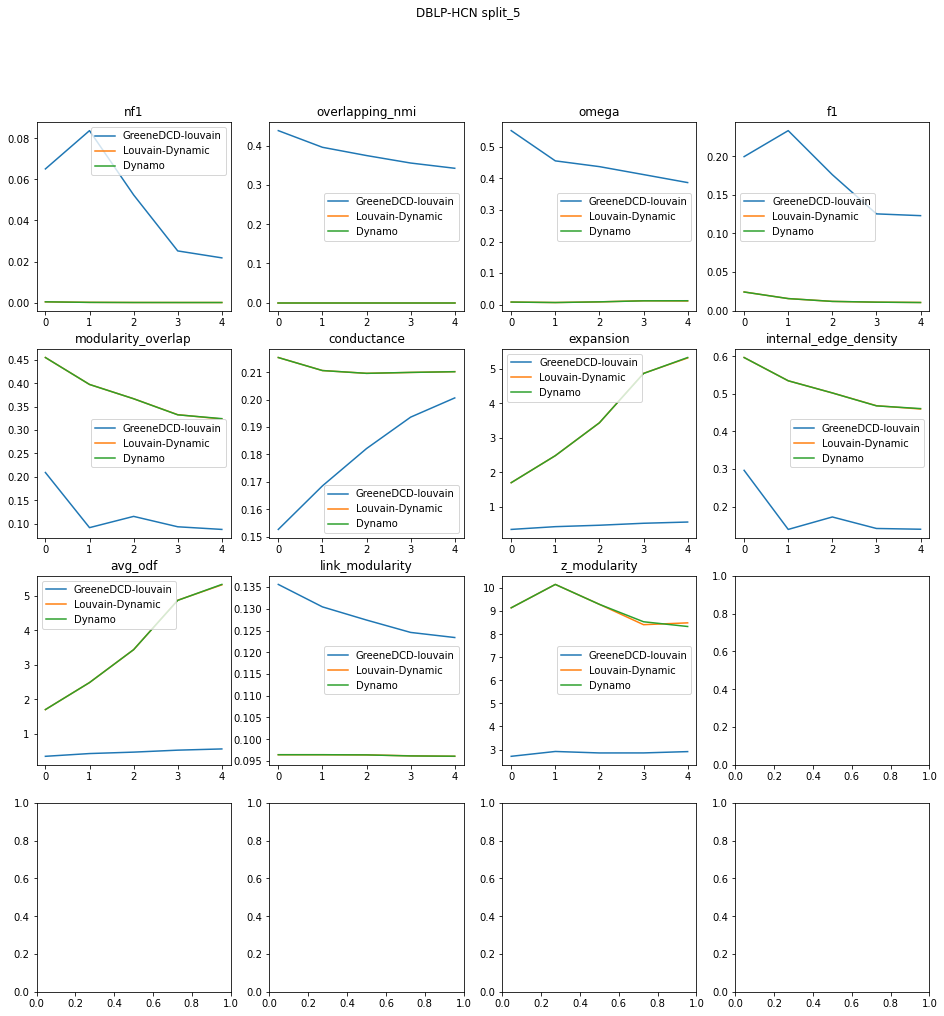

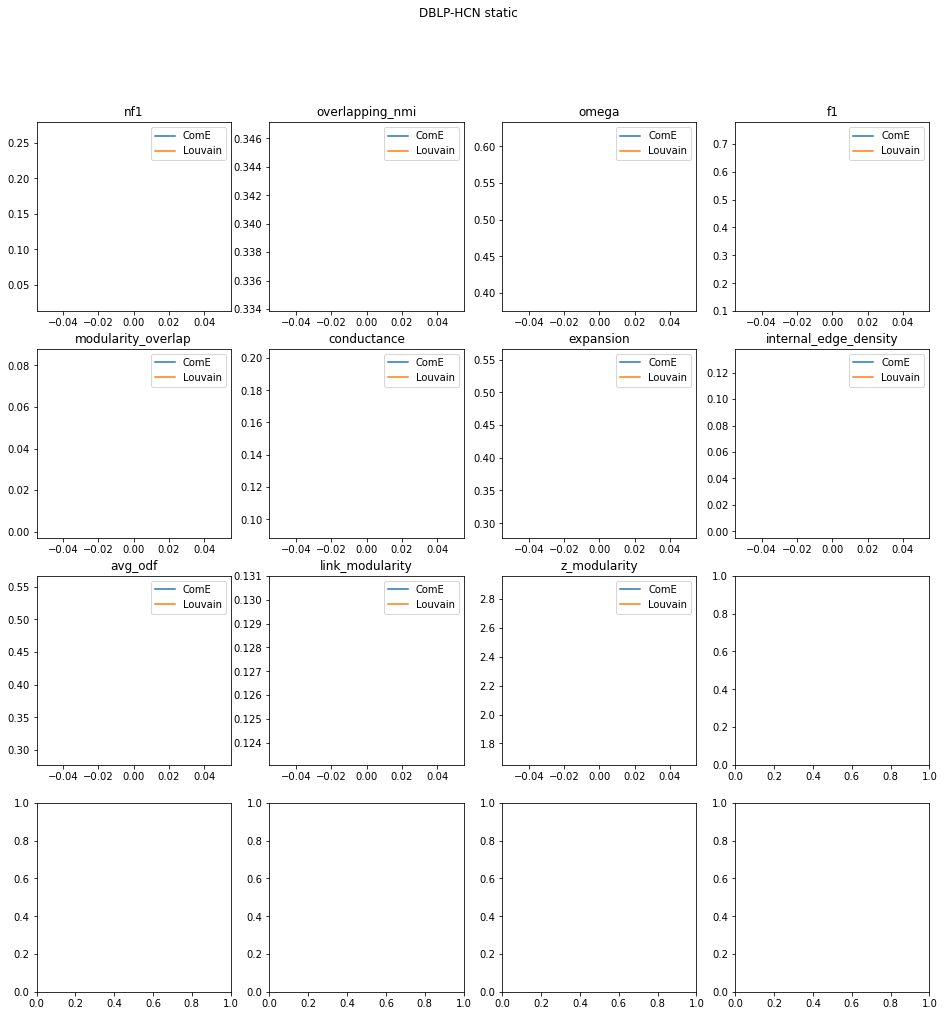

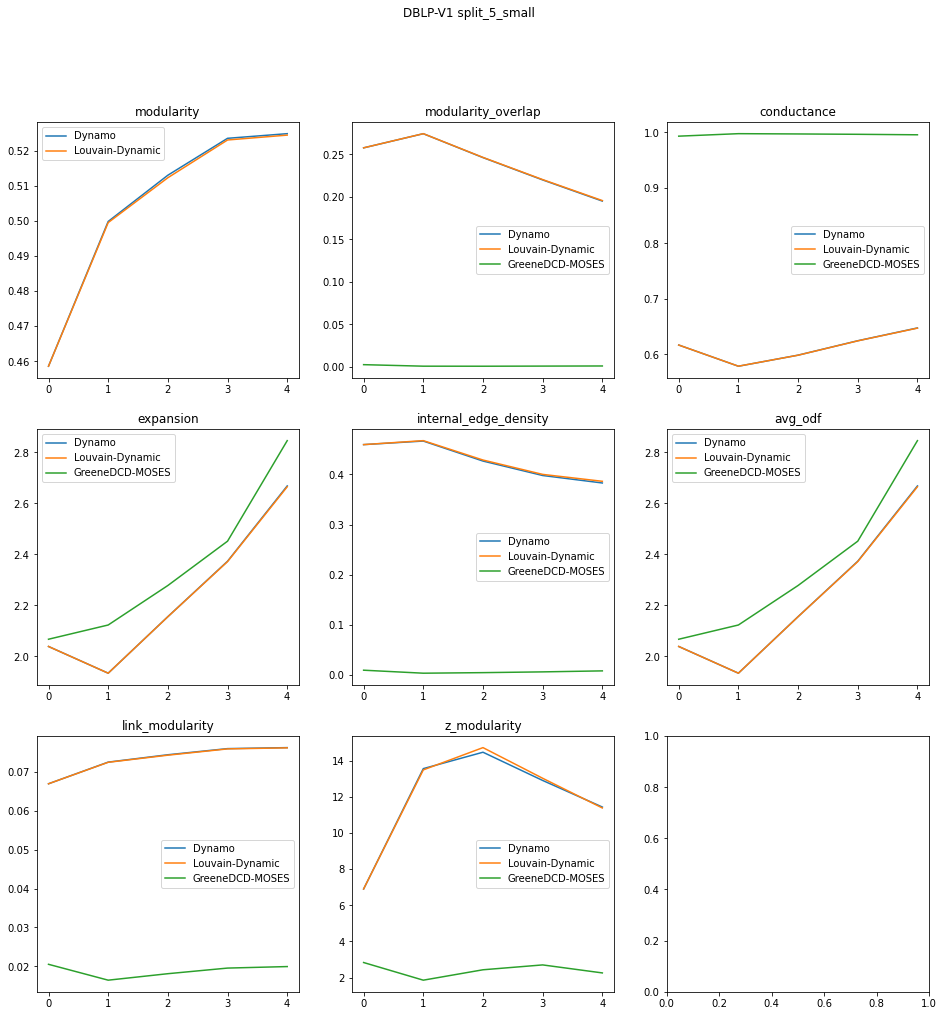

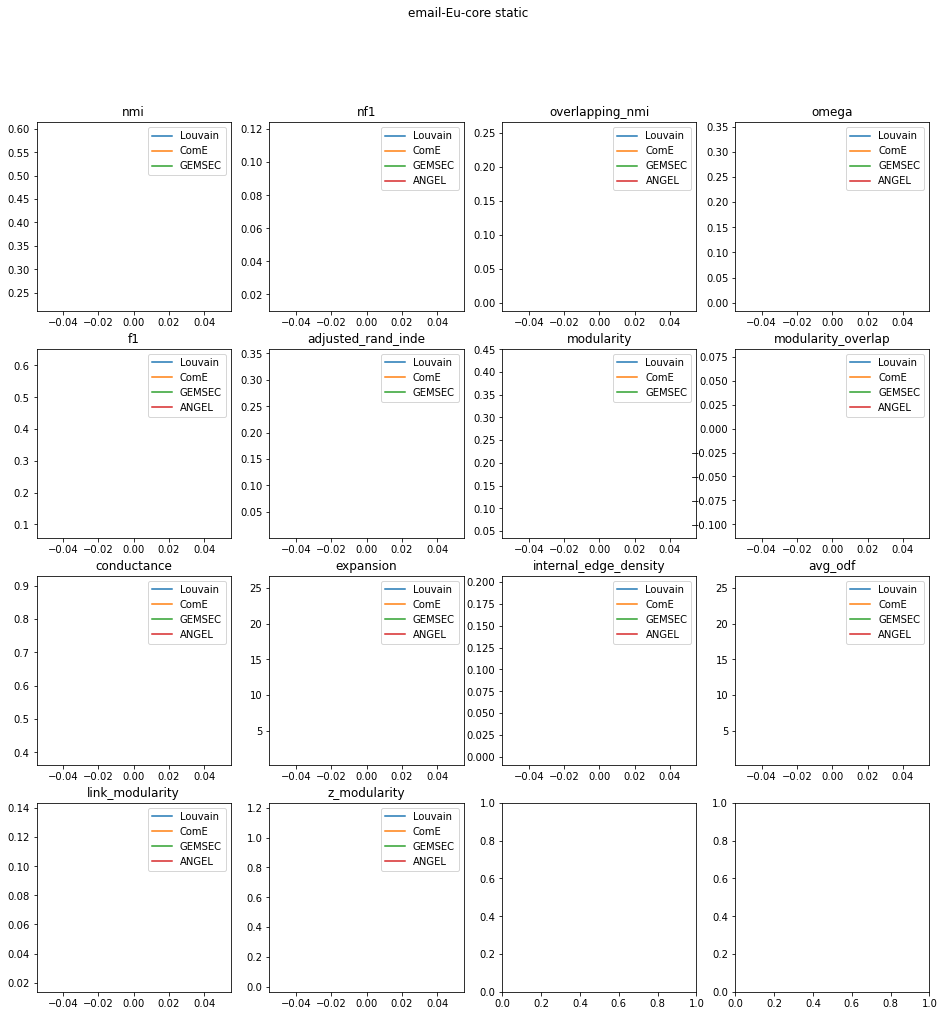

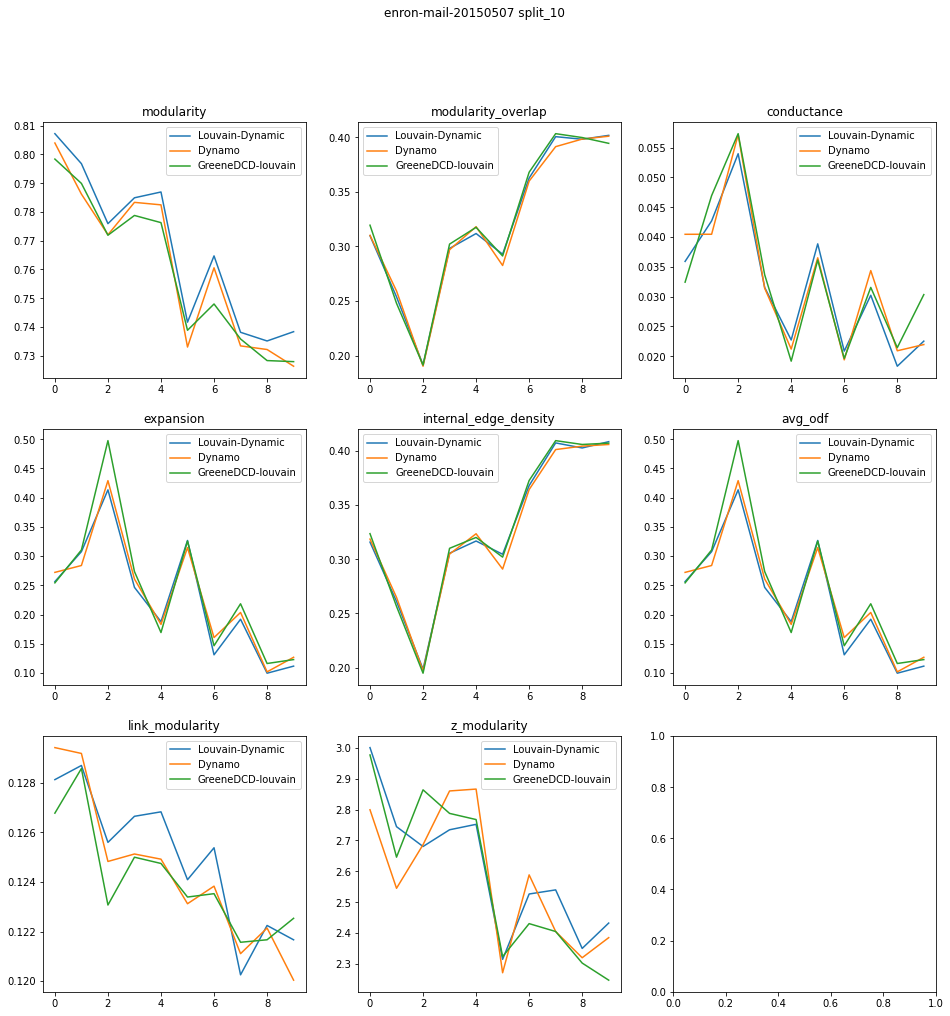

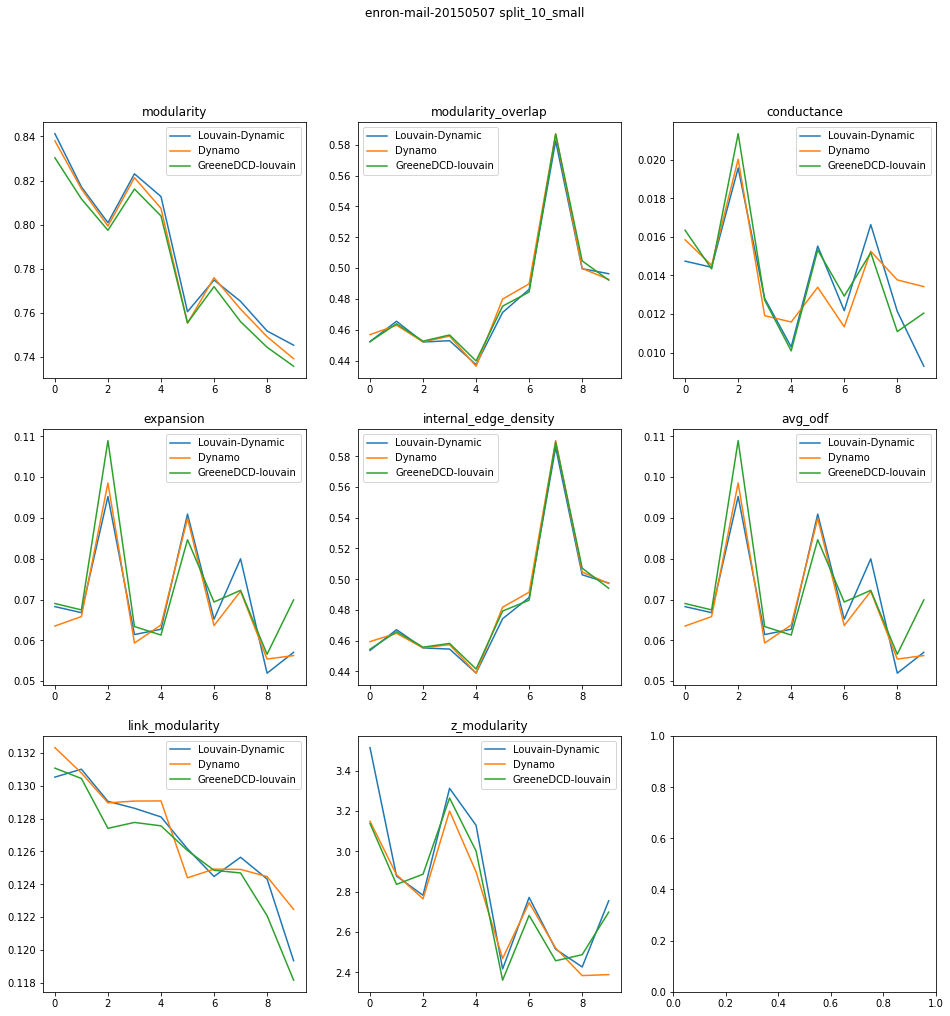

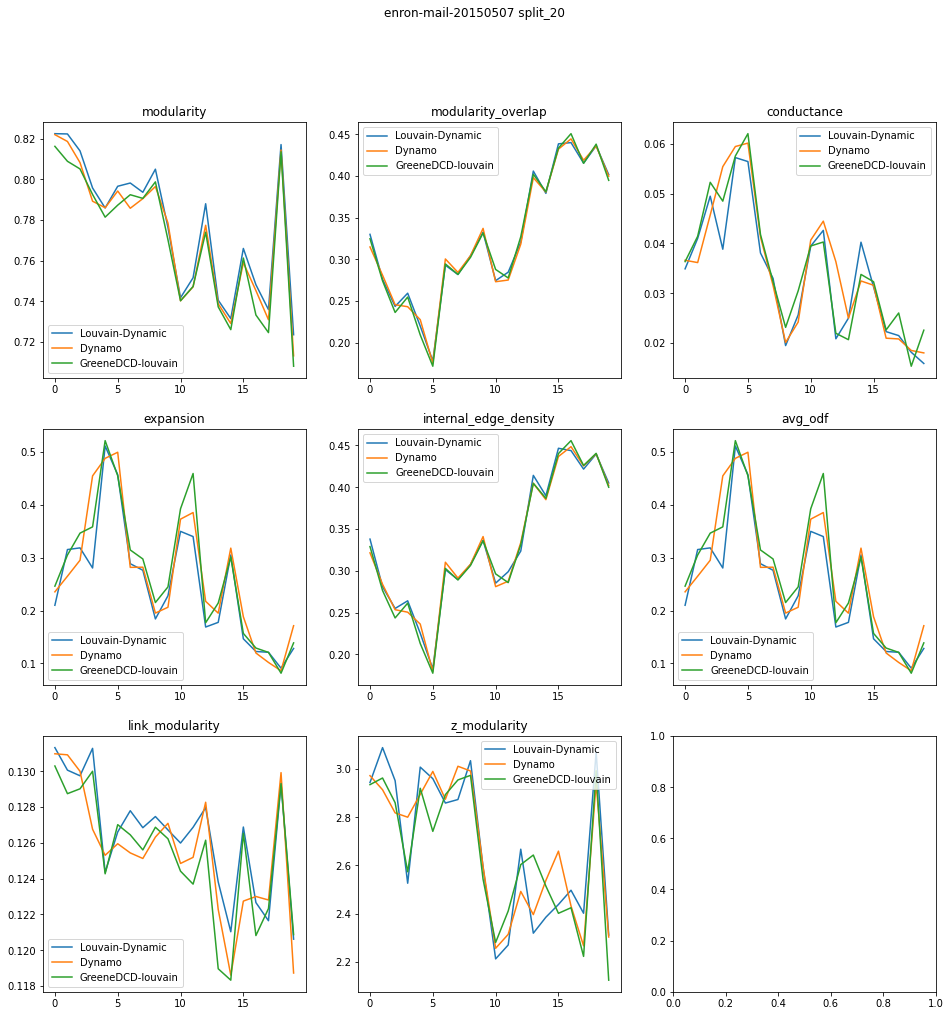

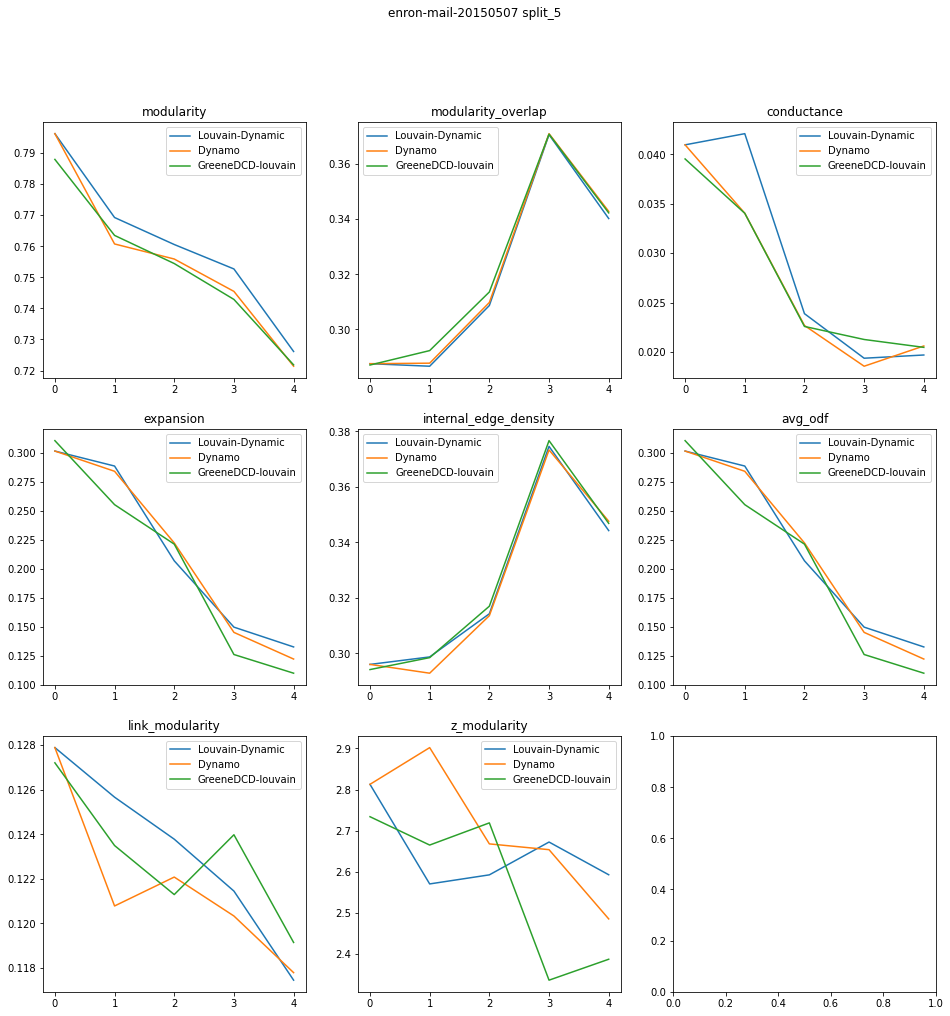

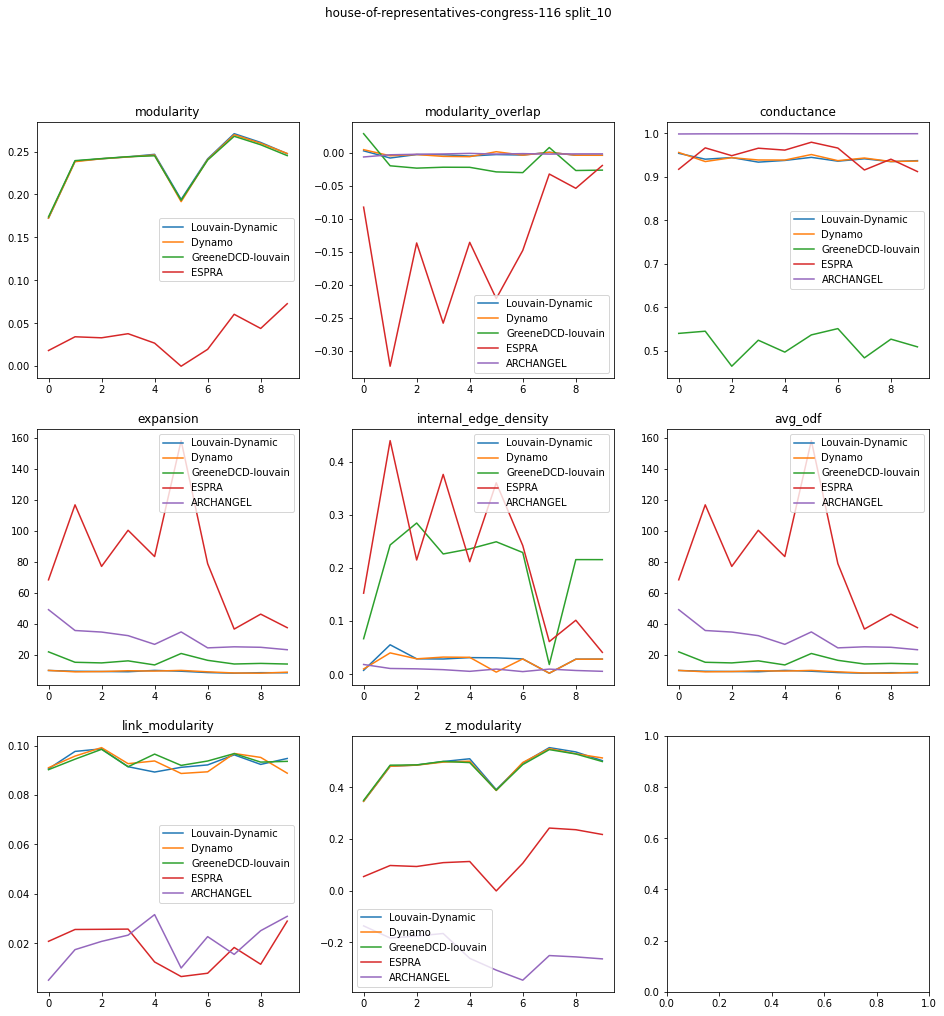

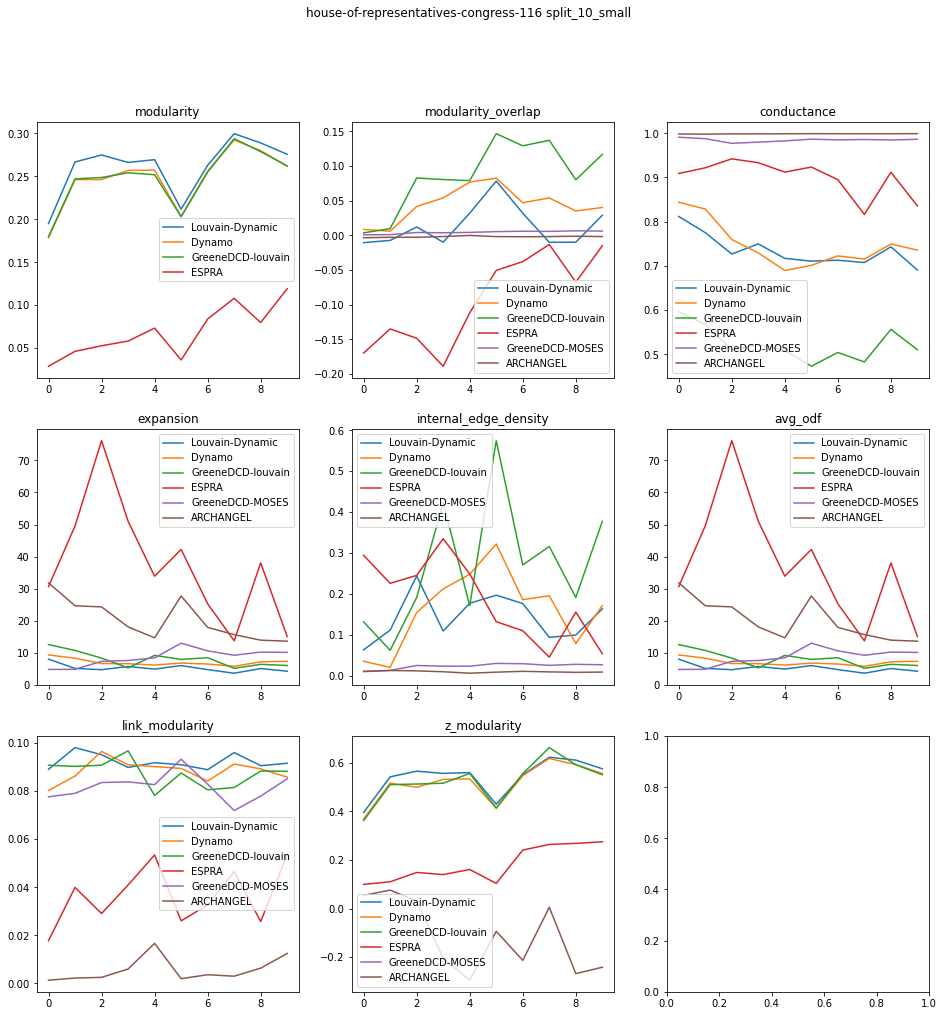

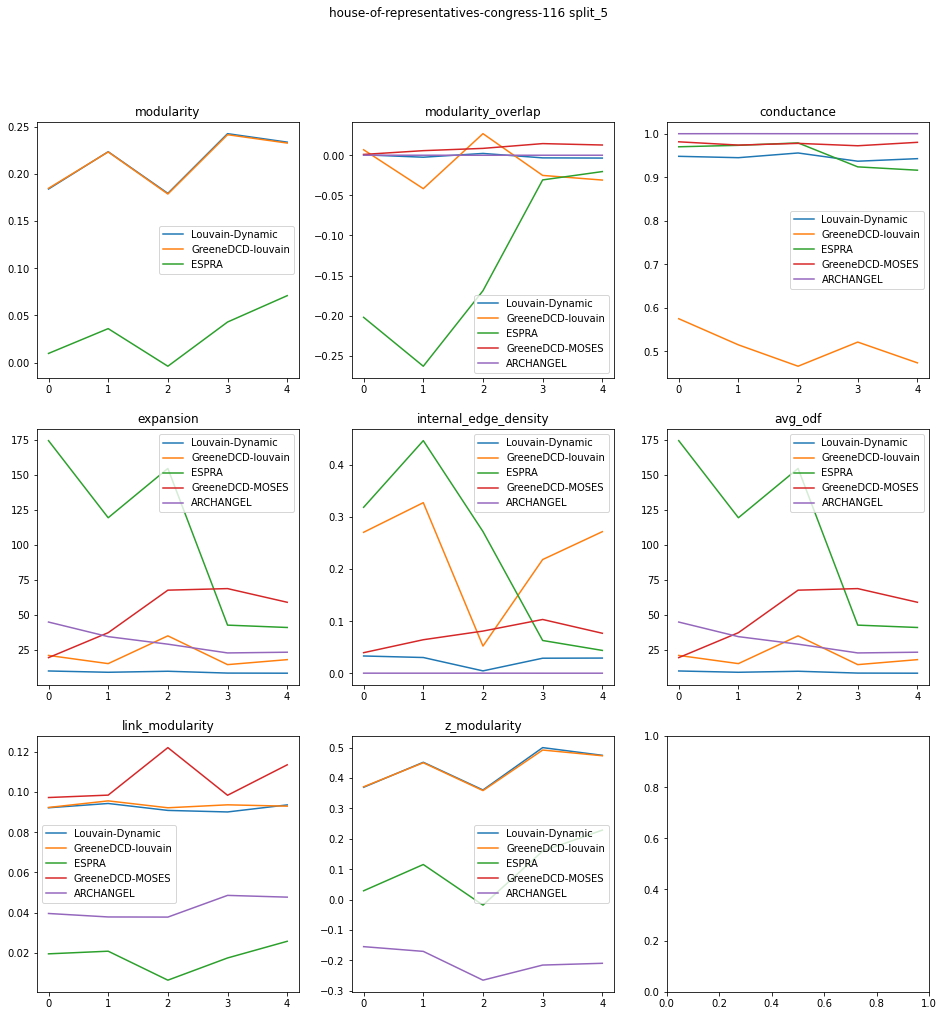

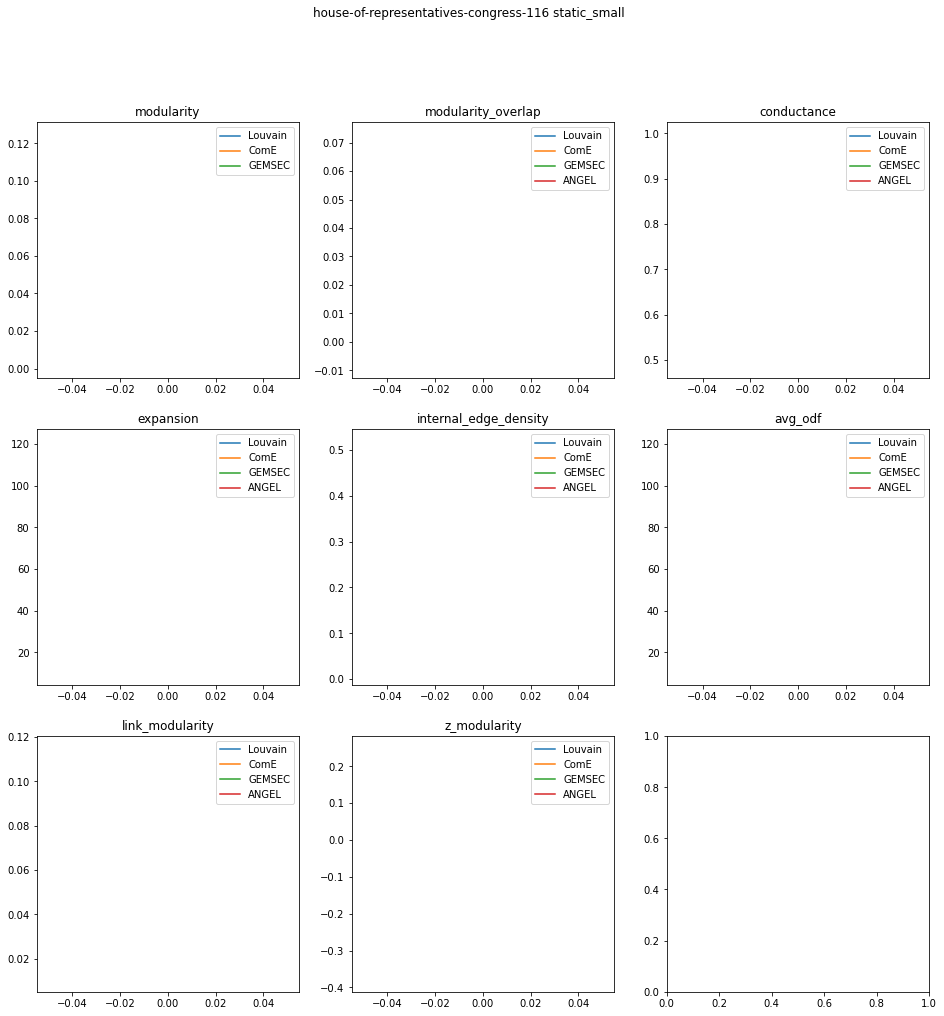

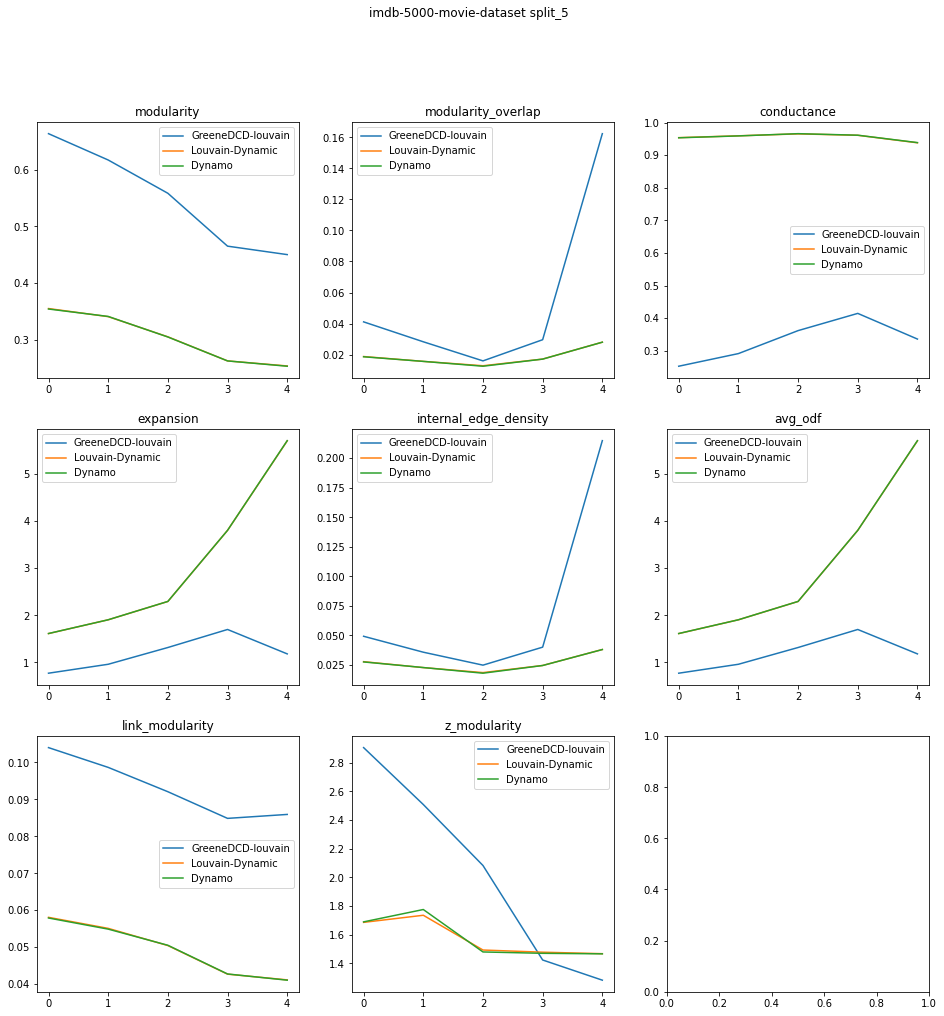

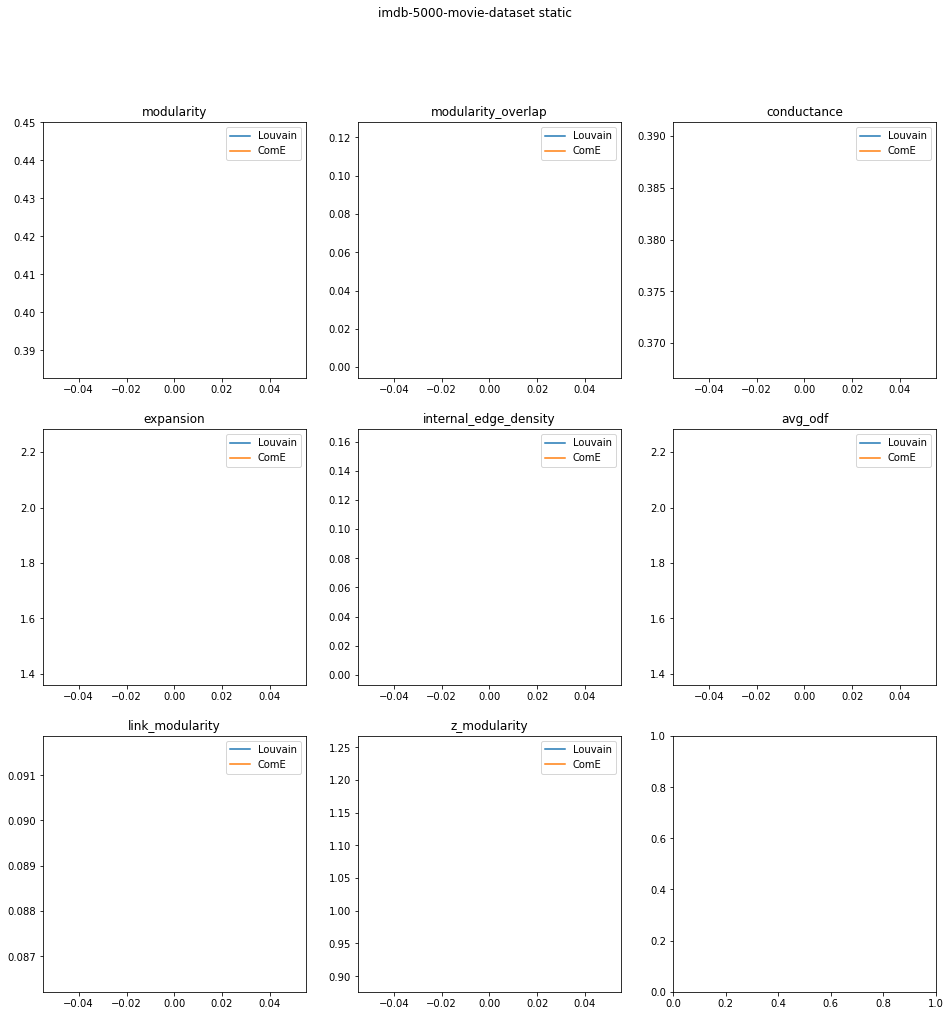

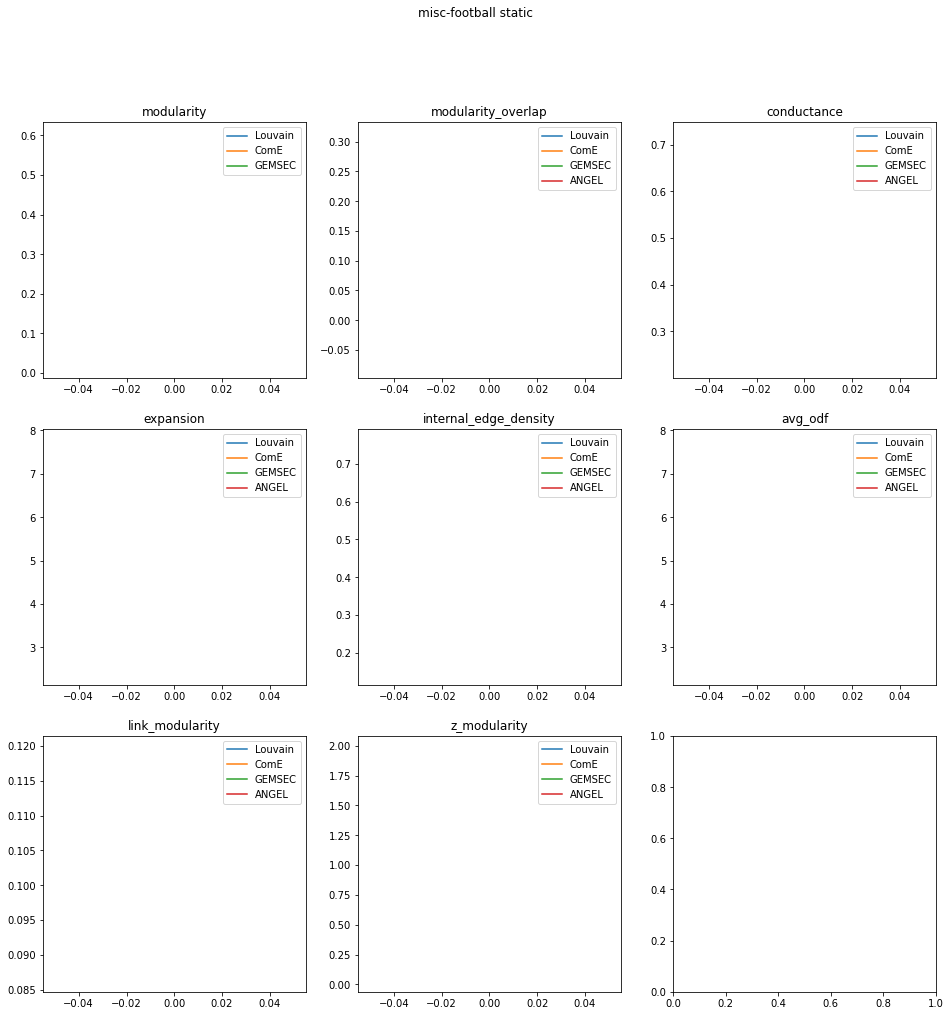

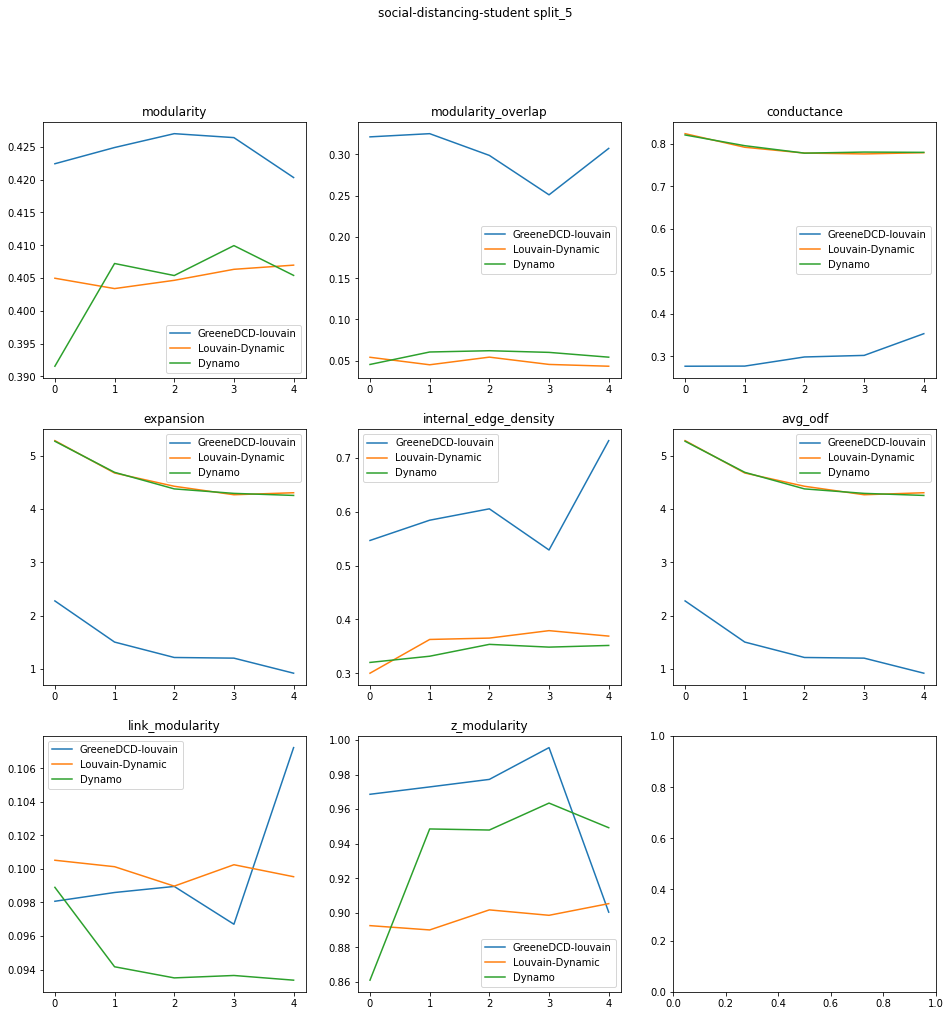

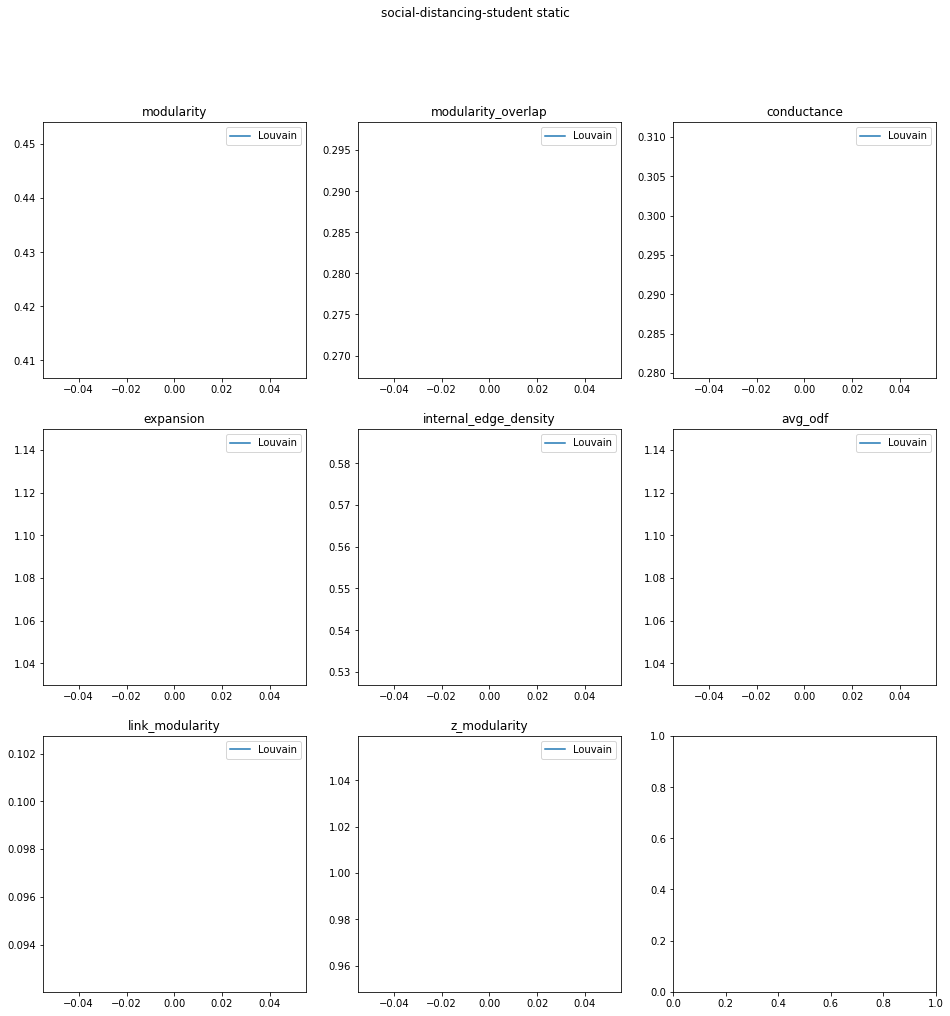

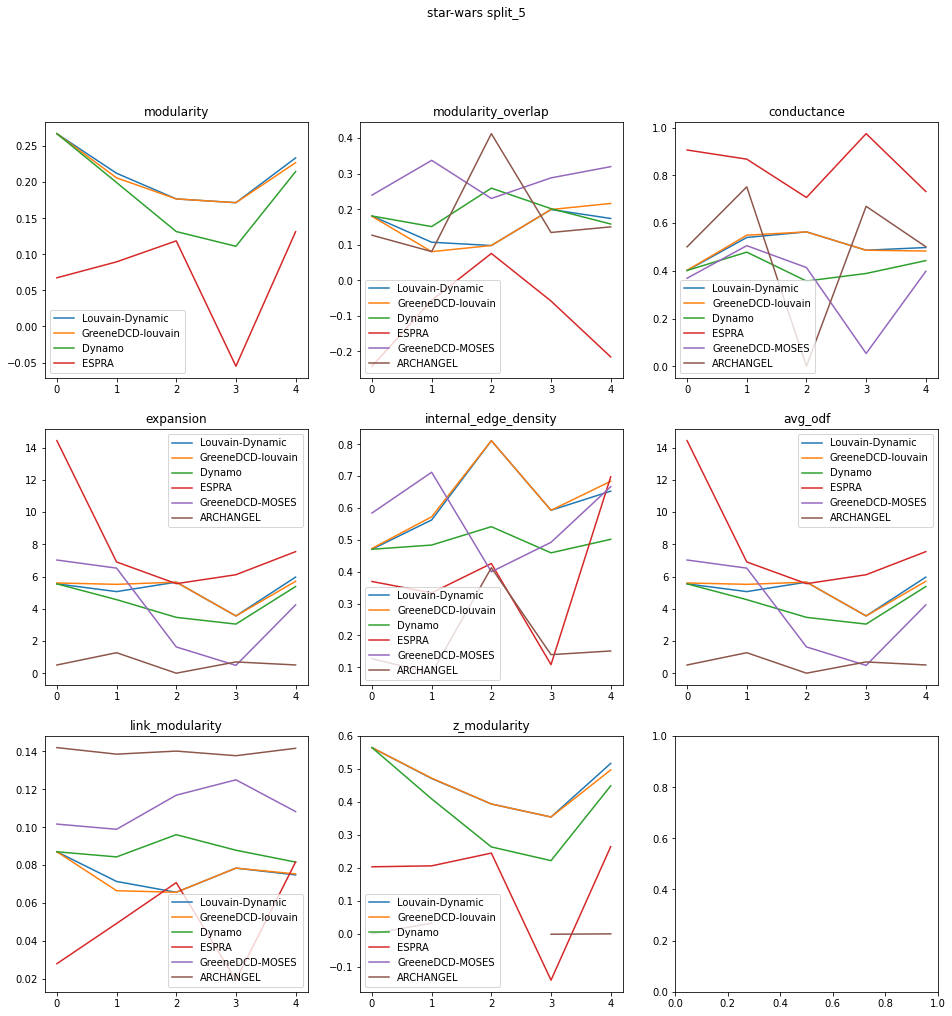

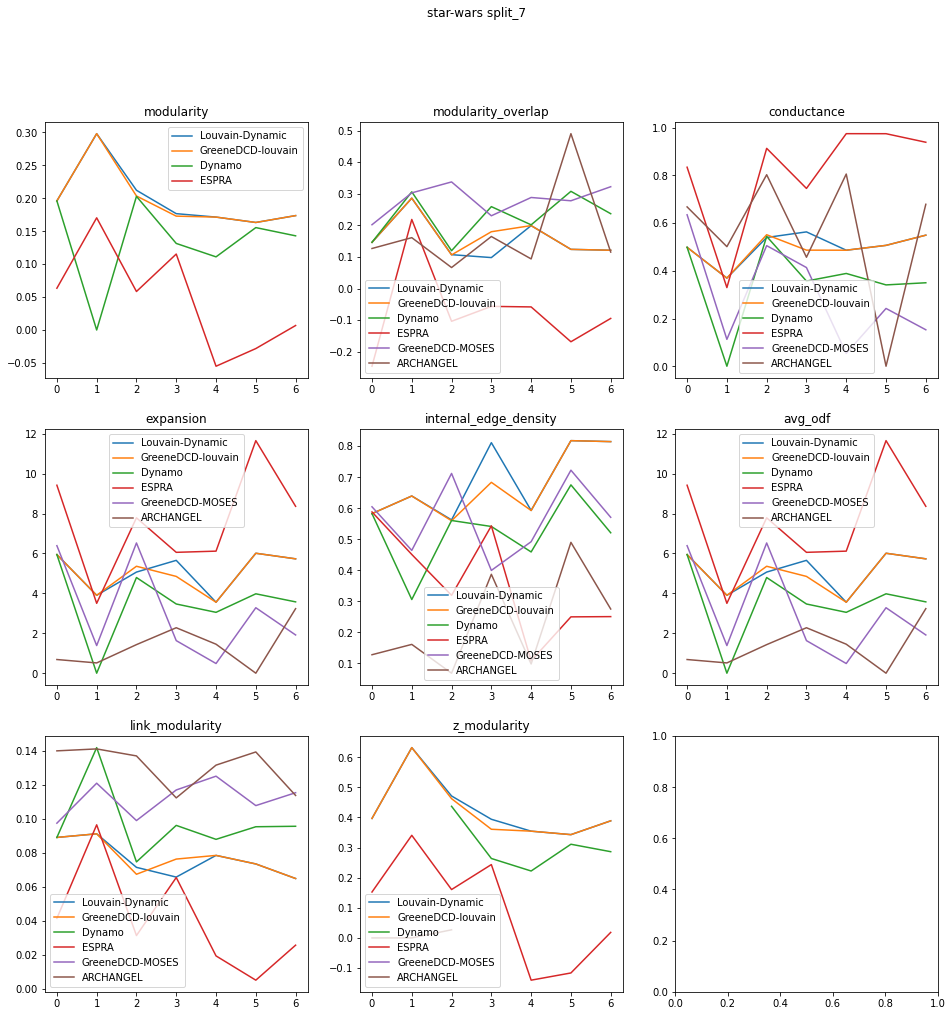

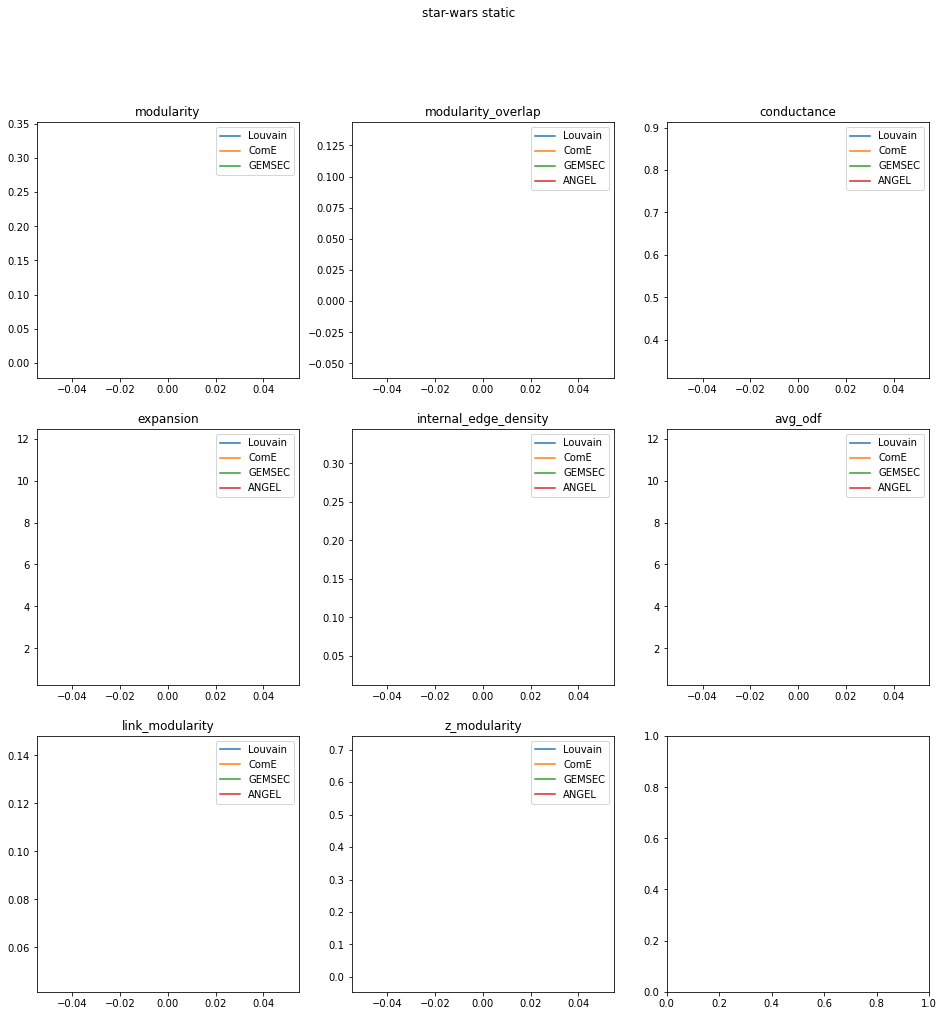

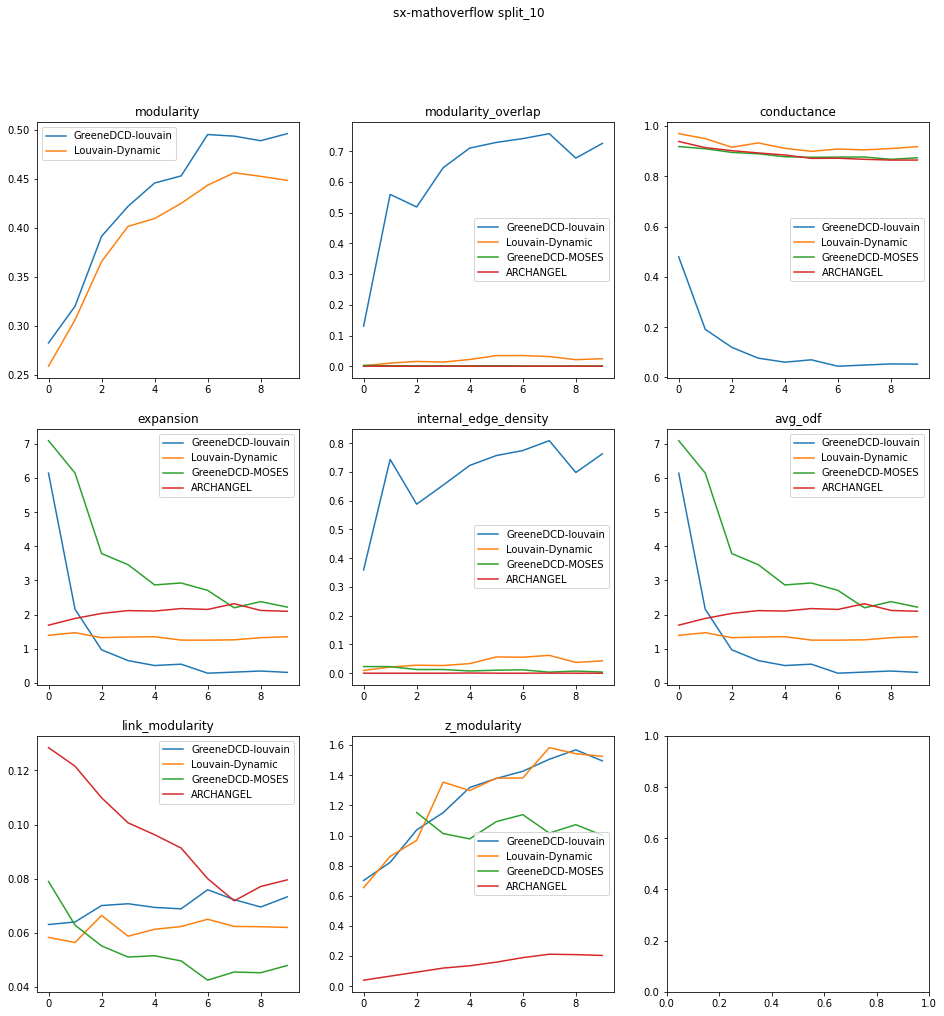

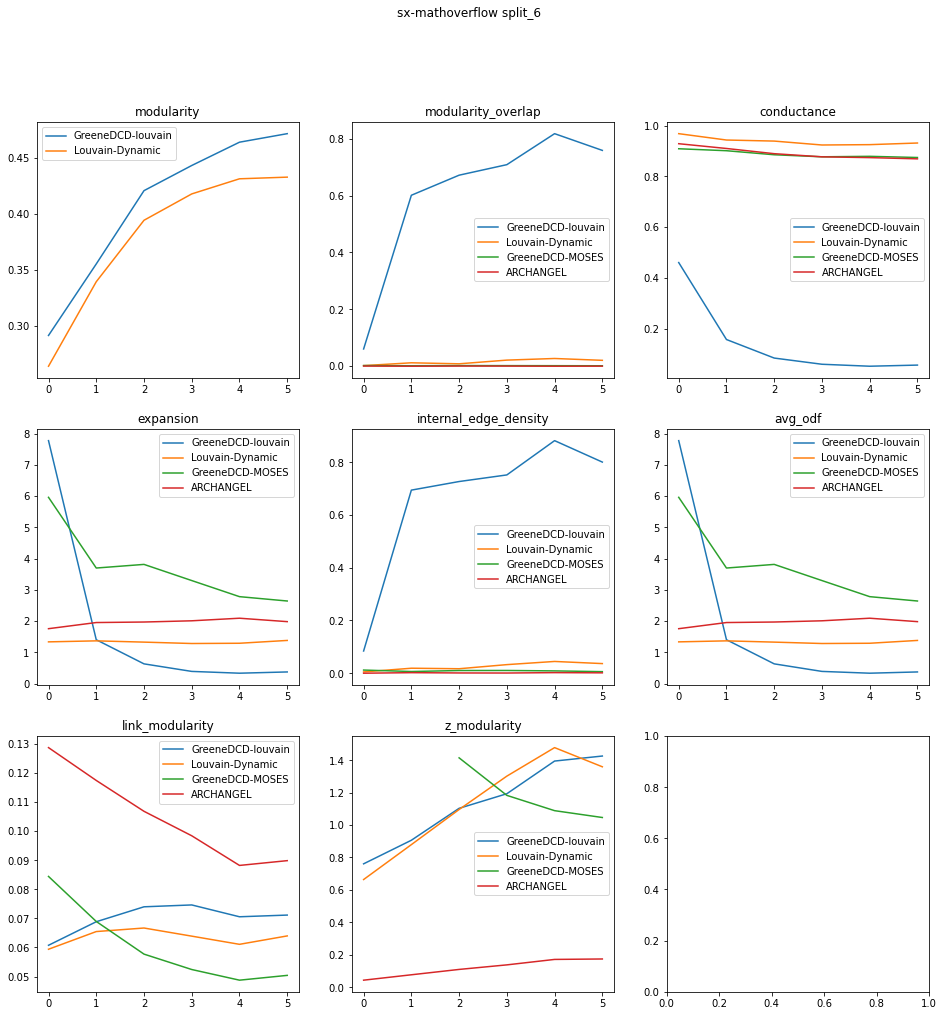

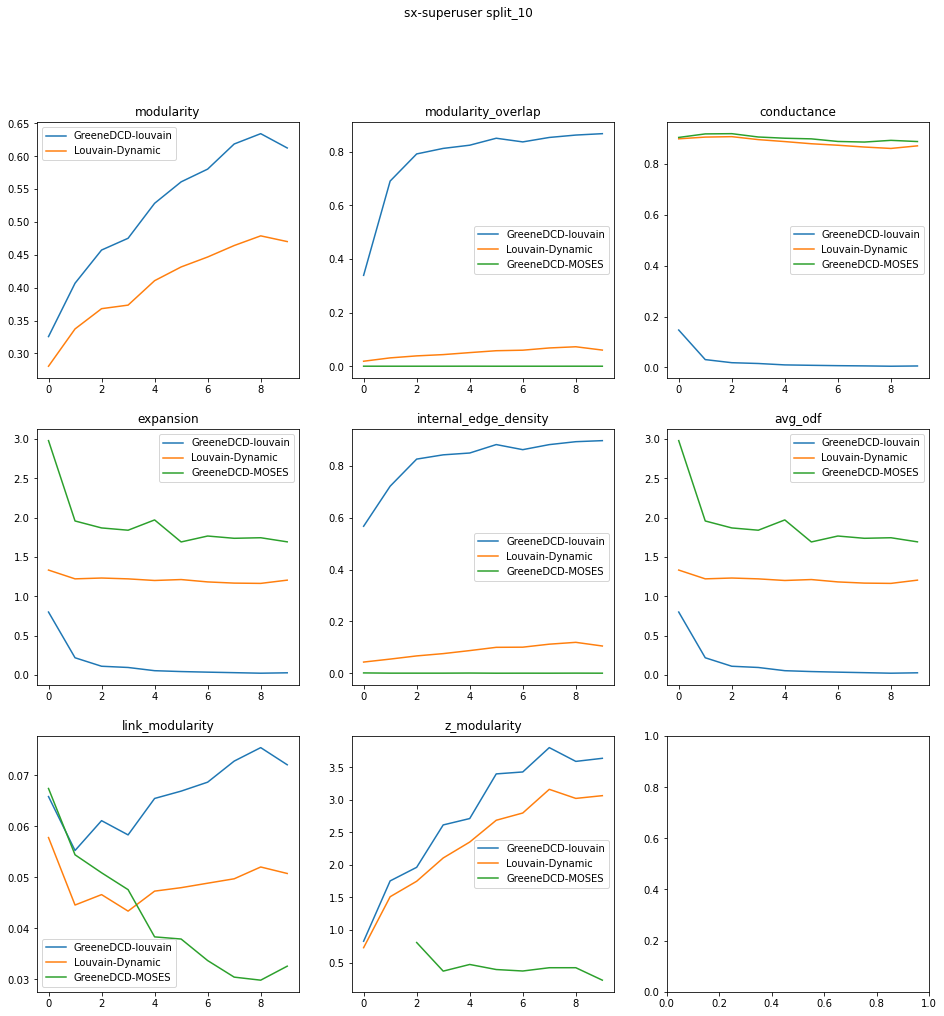

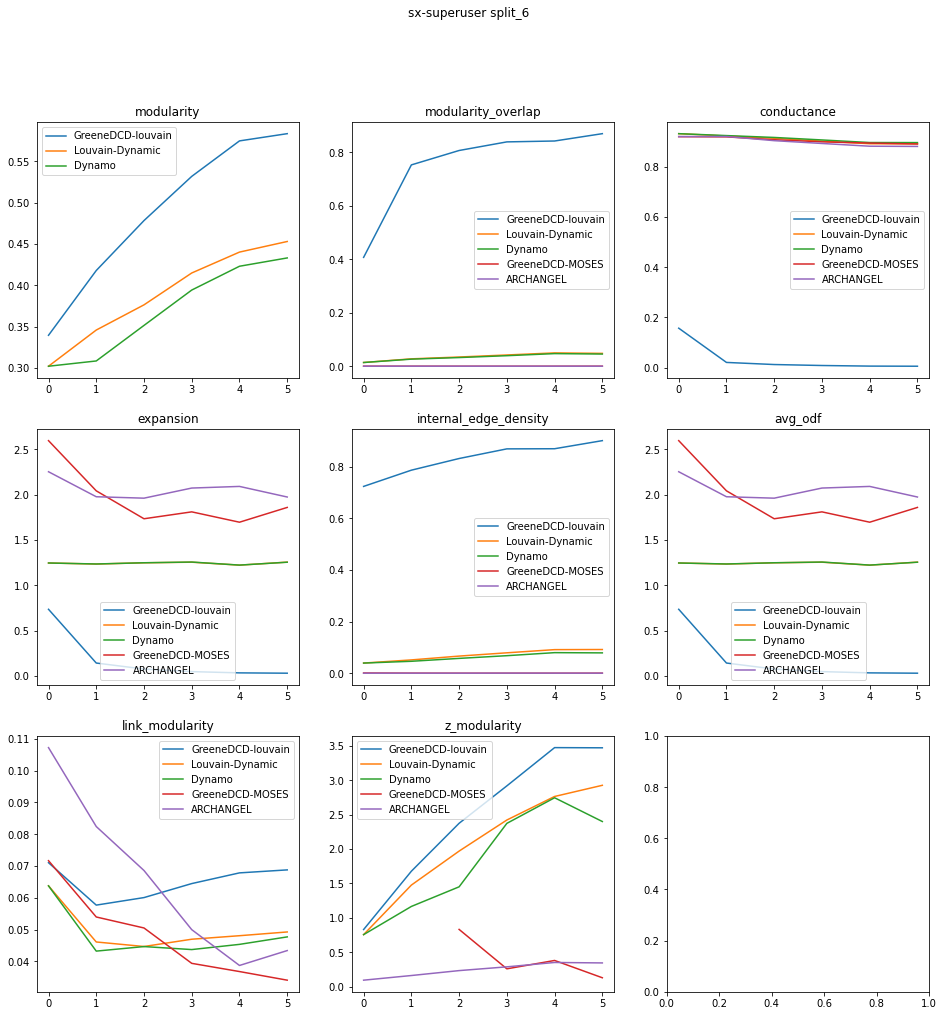

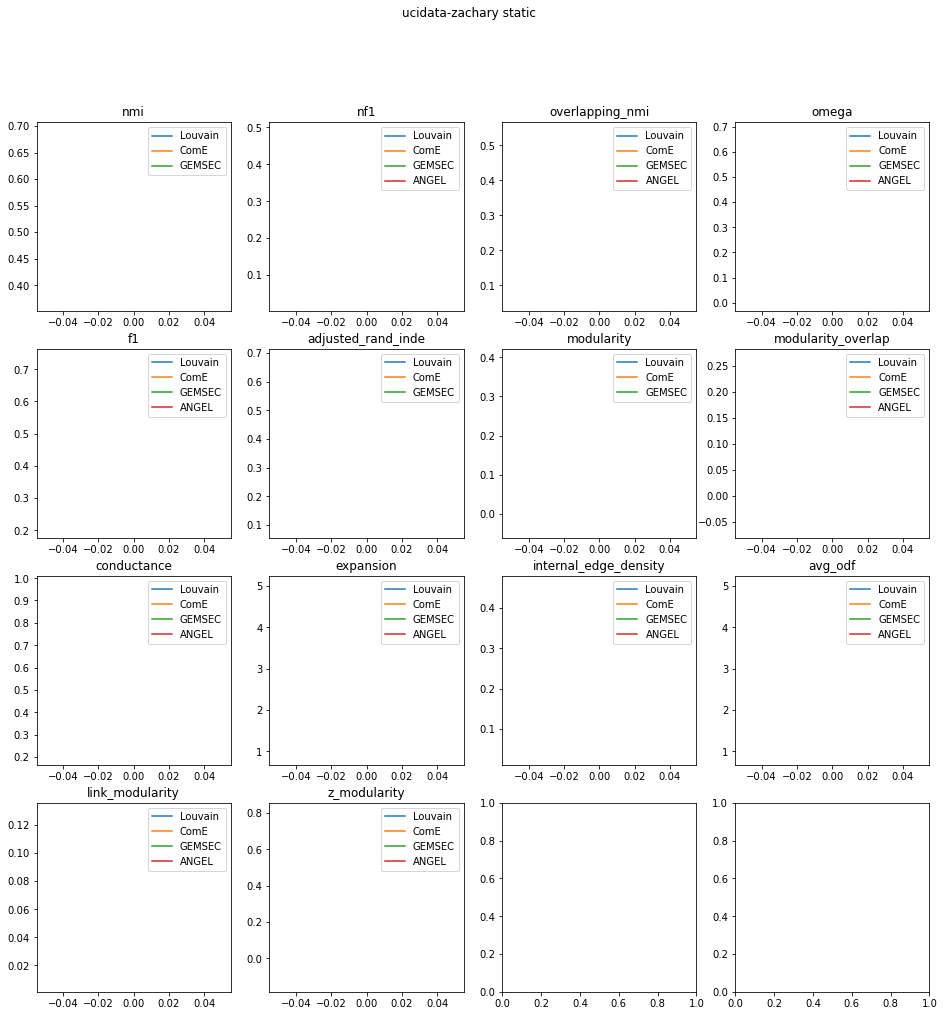

In [9]:
dataset_results_dfs = {}

for (dataset, version), df in runs_dfs.items():
    print(f'Processing {dataset} {version}')
    df = aggregate_metrics_by_baseline(df, dataset, version)
    df.to_csv(str(baseline_dataset_results_dir.joinpath(f'{dataset}_{version}.csv')), index=True)
    dataset_results_dfs[(dataset, version)] = df

In [10]:
static_dataset_results_dfs = {
    (dataset, version): df
    for (dataset, version), df in dataset_results_dfs.items()
    if version == 'static' or version == 'static_small'
}

dynamic_dataset_results_dfs = {
    (dataset, version): df
    for (dataset, version), df in dataset_results_dfs.items()
    if version != 'static' and version != 'static_small'
}

In [11]:
from collections import defaultdict


def aggregate_metrics_by_type(dfs: Dict[Tuple[str, str], pd.DataFrame]):
    baselines = defaultdict(dict)
    for (dataset, version), df in dfs.items():
        for baseline, rank in df['total'].rank(ascending=False).iteritems():
            baselines[baseline][f'{dataset}:{version}'] = rank

    result_df = pd.DataFrame(baselines).T
    result_df.index.name = 'baseline'
    result_df = result_df[~result_df.isna().all(axis=1)]
    result_df['total'] = (result_df == 1).sum(axis=1)

    return result_df

In [12]:
static_results_df = aggregate_metrics_by_type(static_dataset_results_dfs)
static_results_df.to_csv(str(baseline_results_dir.joinpath('static_results.csv')), index=True)
static_results_df

,DBLP-HCN:static,email-Eu-core:static,house-of-representatives-congress-116:static_small,imdb-5000-movie-dataset:static,misc-football:static,star-wars:static,ucidata-zachary:static,social-distancing-student:static,total
baseline,,,,,,,,,
ComE,1.0,4.0,2.0,2.0,2.0,3.5,3.0,NaN,1
Louvain,2.0,1.0,1.0,1.0,1.0,1.5,1.0,1.0,6
GEMSEC,NaN,3.0,4.0,NaN,3.5,3.5,3.0,NaN,0
ANGEL,NaN,2.0,3.0,NaN,3.5,1.5,3.0,NaN,0


In [13]:
dynamic_results_df = aggregate_metrics_by_type(dynamic_dataset_results_dfs)
dynamic_results_df.to_csv(str(baseline_results_dir.joinpath('dynamic_results.csv')), index=True)
dynamic_results_df

,DBLP-HCN:split_5,enron-mail-20150507:split_10,enron-mail-20150507:split_10_small,enron-mail-20150507:split_20,enron-mail-20150507:split_5,house-of-representatives-congress-116:split_10,house-of-representatives-congress-116:split_10_small,house-of-representatives-congress-116:split_5,imdb-5000-movie-dataset:split_5,social-distancing-student:split_5,star-wars:split_5,star-wars:split_7,sx-mathoverflow:split_10,sx-mathoverflow:split_6,sx-superuser:split_10,sx-superuser:split_6,DBLP-V1:split_5_small,total
baseline,,,,,,,,,,,,,,,,,,
GreeneDCD-louvain,1.0,2.0,3.0,2.5,1.0,3.5,2.0,5.0,1.0,1.0,3.5,5.5,1.0,1.5,1.0,1.0,NaN,7
Louvain-Dynamic,2.5,1.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,3.5,2.0,2.5,1.5,3.0,4.5,1.0,6
Dynamo,2.5,3.0,1.0,2.5,3.0,3.5,5.0,NaN,2.0,2.0,6.0,5.5,NaN,NaN,NaN,2.5,2.0,1
GreeneDCD-MOSES,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.5,3.5,4.0,4.0,2.0,4.5,3.0,0
ESPRA,NaN,NaN,NaN,NaN,NaN,3.5,5.0,3.5,NaN,NaN,3.5,3.5,NaN,NaN,NaN,NaN,NaN,0
ARCHANGEL,NaN,NaN,NaN,NaN,NaN,3.5,3.0,3.5,NaN,NaN,1.0,1.0,2.5,3.0,NaN,2.5,NaN,2
